**Installing Dependencies**

In [1]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
!pip install kaggle
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.

**Importing useful libraries**

In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil

from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

**Mounting drive to get data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Defining functions for data visualization and normalization**

In [4]:
# Defining helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
# Defining helper function for data normalization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

**Defining classes for data loading and preprocessing**

In [37]:
# Class for data loading and preprocessing
class Dataset:
    """Read images, apply preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['disease']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.img_ids = os.listdir(images_dir)
        self.msk_ids = os.listdir(masks_dir)
        self.ids = [img_id.split(".")[0] for img_id in self.img_ids]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.images_fps = [img_id + ".jpg" for img_id in self.images_fps]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.masks_fps = [img_id + ".png" for img_id in self.masks_fps]

        # Converting str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # Reading the data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)


        # Extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


In [7]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integer number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # Collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [8]:
def get_preprocessing(preprocessing_fn):
    """Constructing preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

**Visualizing some images and their corresponding masks**

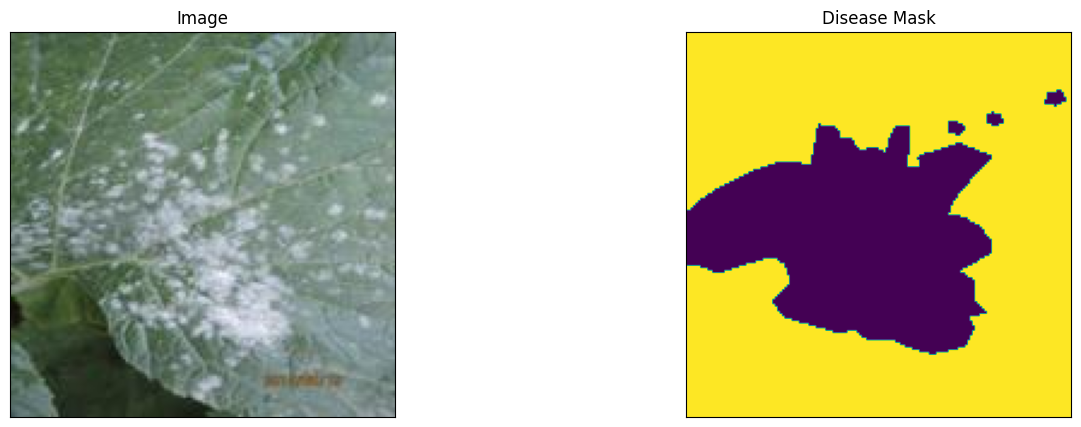

In [9]:
train_image_dir = "/content/drive/MyDrive/Semantic Segmentation/data/train/images"
train_mask_dir = "/content/drive/MyDrive/Semantic Segmentation/data/train/masks"
# Lets look at data we have
dataset = Dataset(train_image_dir, train_mask_dir, classes=['disease'])

image, mask = dataset[2] # To get the sample image and mask for ploting

image.shape, mask.shape
visualize(
    image=image,
    disease_mask=mask[..., 0].squeeze()
)

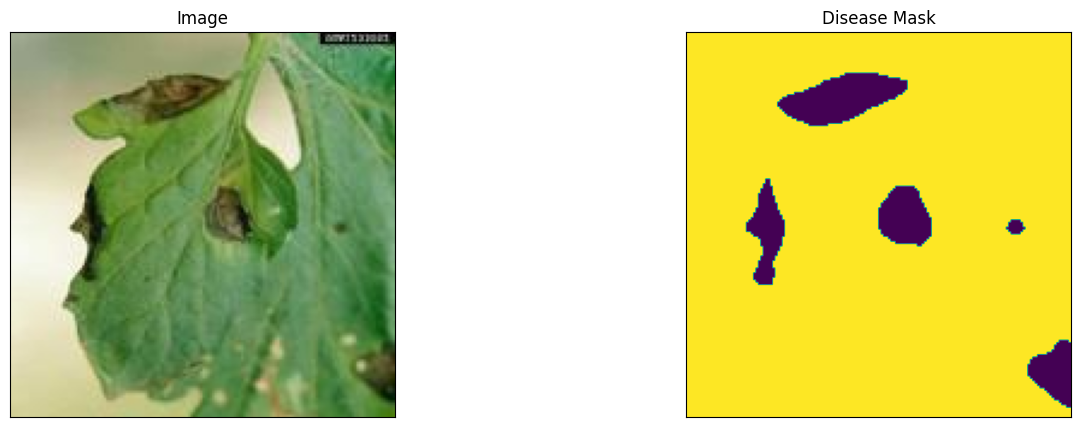

In [10]:
image, mask = dataset[3] # To get the sample image and mask for ploting

image.shape, mask.shape
visualize(
    image=image,
    disease_mask=mask[..., 0].squeeze()
)

**Defining network backbone and some hyperparameters**

In [11]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['disease']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

**Defining network parameters and creating model**

In [12]:
# Defining the network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#Creating the model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44107200/44107200 [==============================] - 0s 0us/step


In [13]:
# Defining optomizer
optim = keras.optimizers.Adam(LR)

# Combining segmentation models losses together by '+' and scaling by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# We can also import losses directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Compiling keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics= ['accuracy', metrics])

In [14]:
import albumentations as A

# Dataset for training images
x_train_dir = "/content/drive/MyDrive/Semantic Segmentation/data/train/images"
y_train_dir = "/content/drive/MyDrive/Semantic Segmentation/data/train/masks"
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input),
)
x_valid_dir = "/content/drive/MyDrive/Semantic Segmentation/data/valid/images"
y_valid_dir = "/content/drive/MyDrive/Semantic Segmentation/data/valid/masks"

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# Checking shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 160, 160, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 160, 160, n_classes)

# Defining callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

**Now, train the model**

In [15]:
# Training model
history = model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)

Epoch 1/10


<ipython-input-15-da8266fee1a6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


257/257 [==============================] - 1109s 4s/step - loss: 0.2168 - accuracy: 0.8545 - iou_score: 0.8359 - f1-score: 0.9092 - val_loss: 0.1901 - val_accuracy: 0.8430 - val_iou_score: 0.8136 - val_f1-score: 0.8886 - lr: 1.0000e-04
Epoch 2/10
257/257 [==============================] - 51s 200ms/step - loss: 0.1355 - accuracy: 0.9107 - iou_score: 0.8954 - f1-score: 0.9442 - val_loss: 0.1244 - val_accuracy: 0.9142 - val_iou_score: 0.8984 - val_f1-score: 0.9440 - lr: 1.0000e-04
Epoch 3/10
257/257 [==============================] - 52s 201ms/step - loss: 0.1085 - accuracy: 0.9280 - iou_score: 0.9146 - f1-score: 0.9549 - val_loss: 0.1173 - val_accuracy: 0.9186 - val_iou_score: 0.9032 - val_f1-score: 0.9468 - lr: 1.0000e-04
Epoch 4/10
257/257 [==============================] - 51s 198ms/step - loss: 0.0909 - accuracy: 0.9395 - iou_score: 0.9278 - f1-score: 0.9621 - val_loss: 0.1201 - val_accuracy: 0.9102 - val_iou_score: 0.8924 - val_f1-score: 0.9407 - lr: 1.0000e-04
Epoch 5/10
257/257 [

**Ploting iou_scores and loss curves**

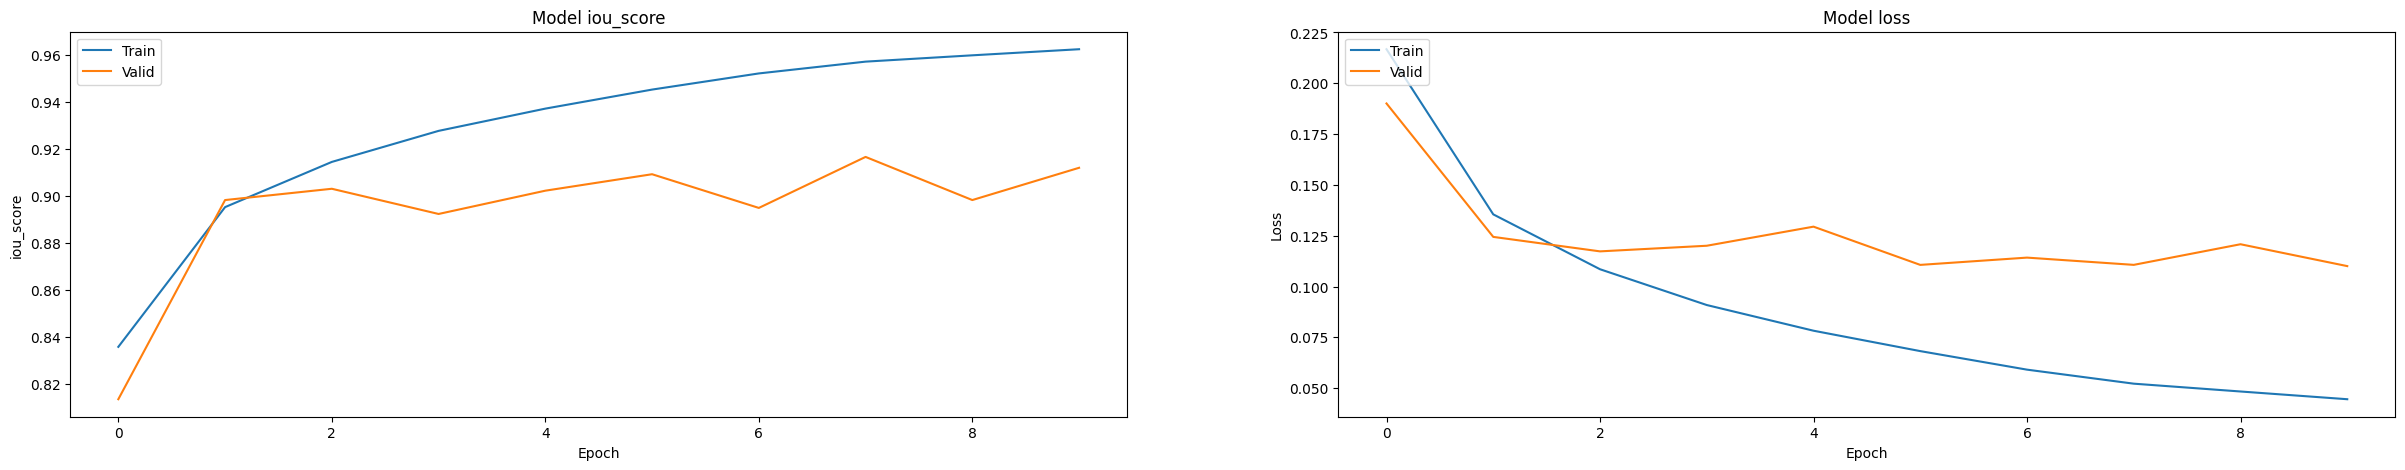

In [16]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [32]:
x_test_dir = "/content/drive/MyDrive/Semantic Segmentation/data/test/images"
y_test_dir = "/content/drive/MyDrive/Semantic Segmentation/data/test/masks"

In [33]:
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input)
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

**Loading the model weights for inference**

In [34]:
model.load_weights('/content/best_model.h5')

**Evaluating the model on test set**

In [38]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

<ipython-input-38-085d0e8f0f9f>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)
Image shape: (160, 160, 3)
Mask shape: (160, 160)


**Predicting masks on some of the test images**

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 4s 4s/step


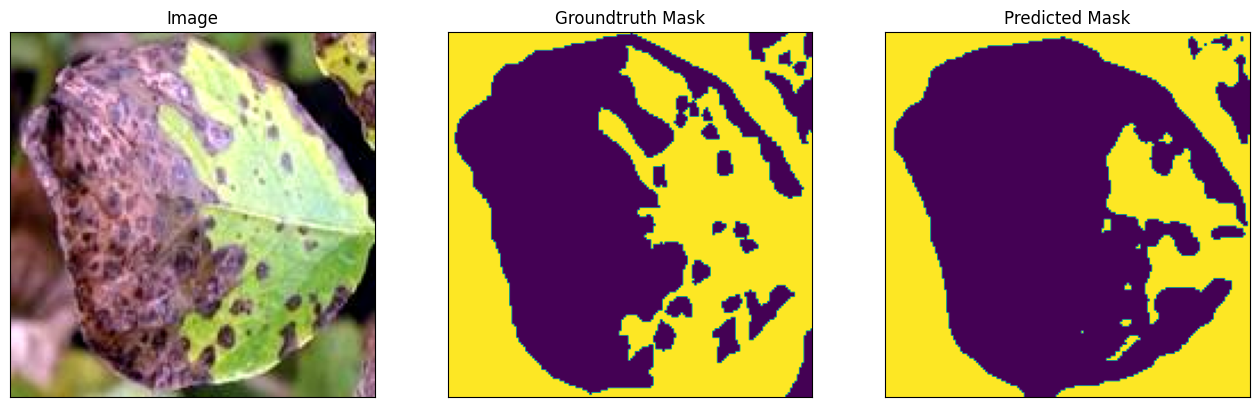

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 0s 56ms/step


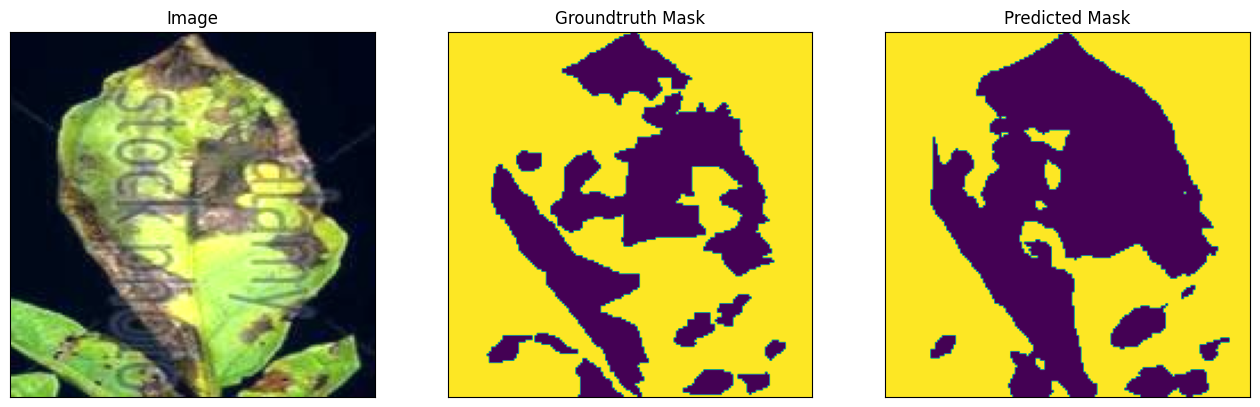

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 0s 30ms/step


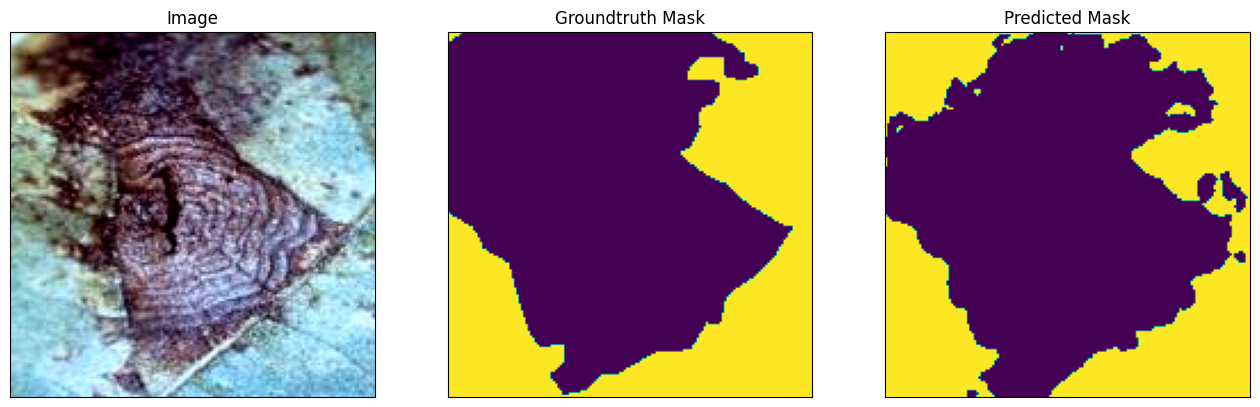

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 0s 41ms/step


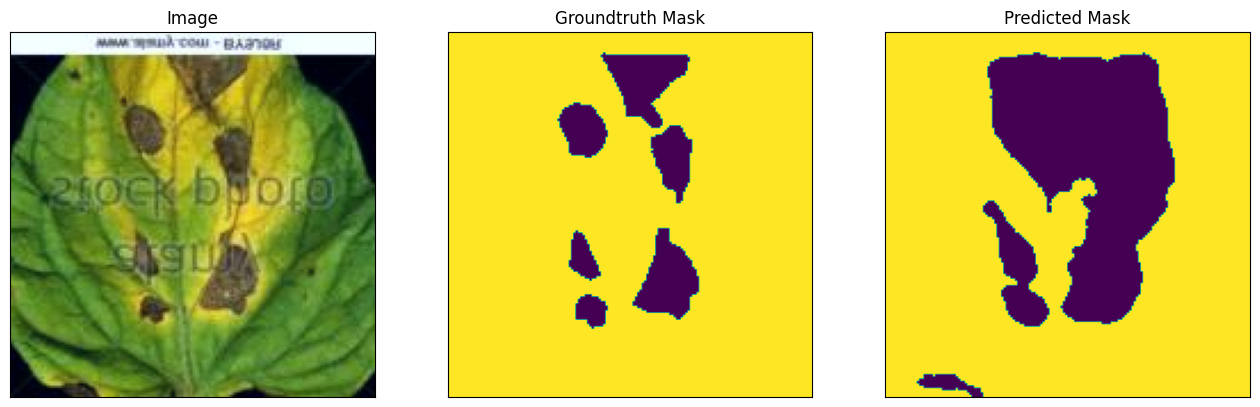

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 0s 38ms/step


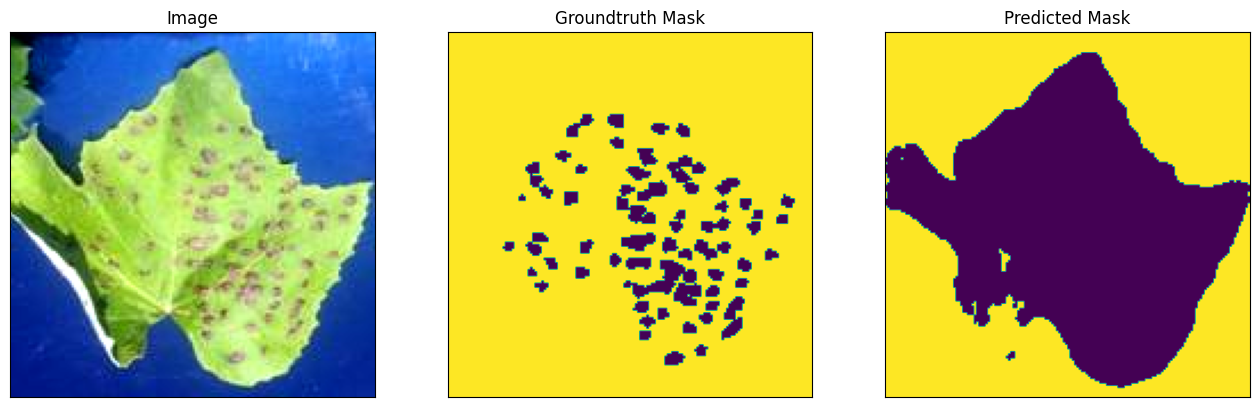

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 0s 35ms/step


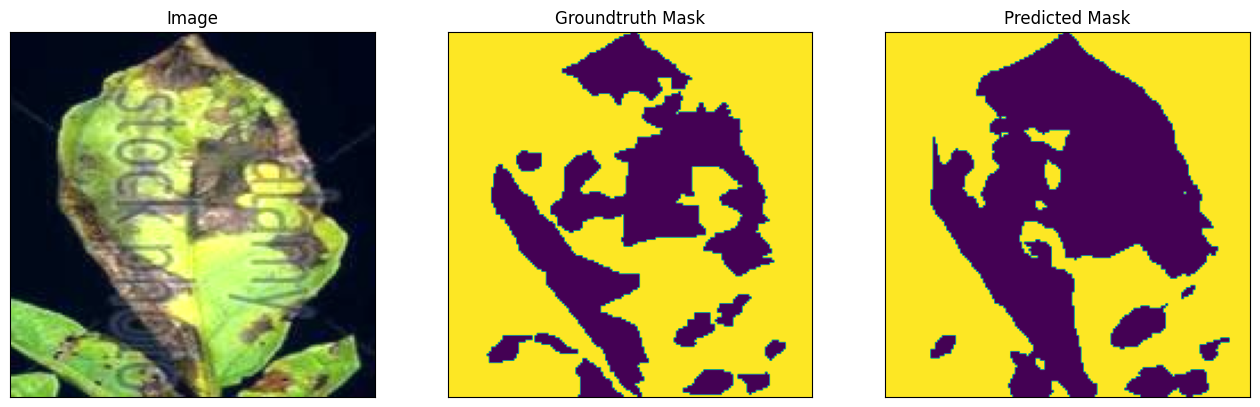

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 0s 30ms/step


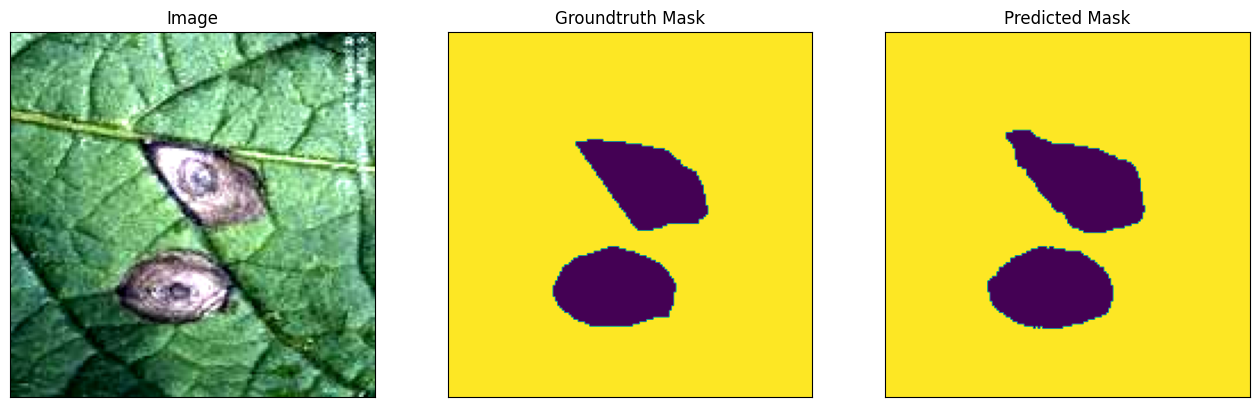

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 0s 33ms/step


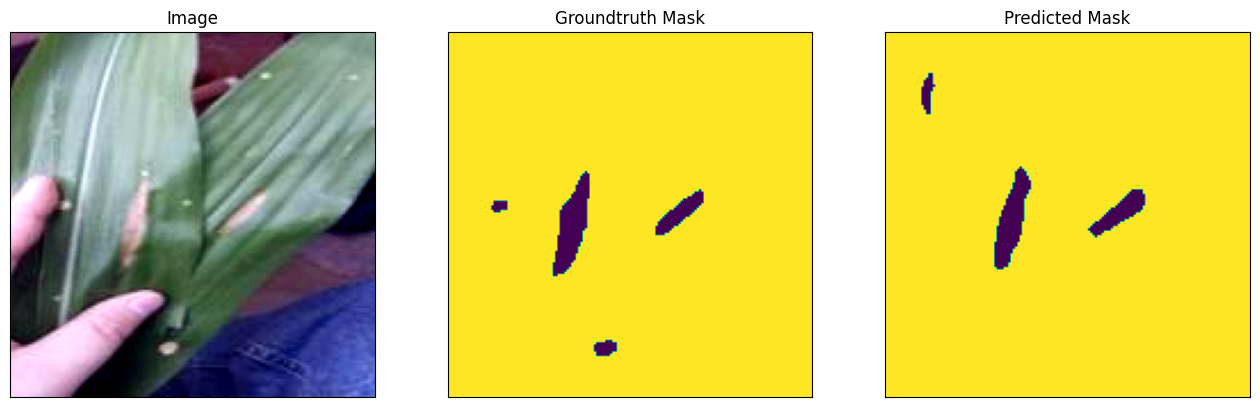

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 0s 30ms/step


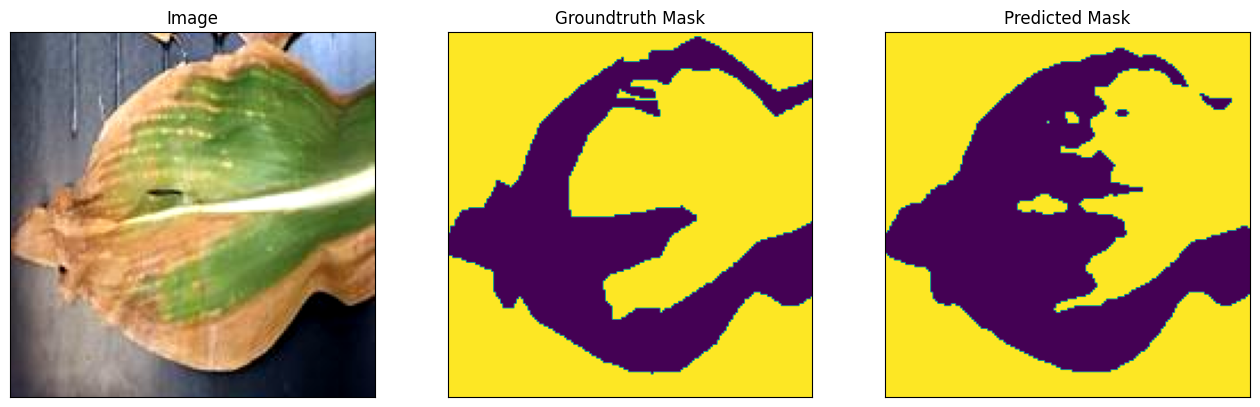

Image shape: (160, 160, 3)
Mask shape: (160, 160)
1/1 [==============================] - 0s 43ms/step


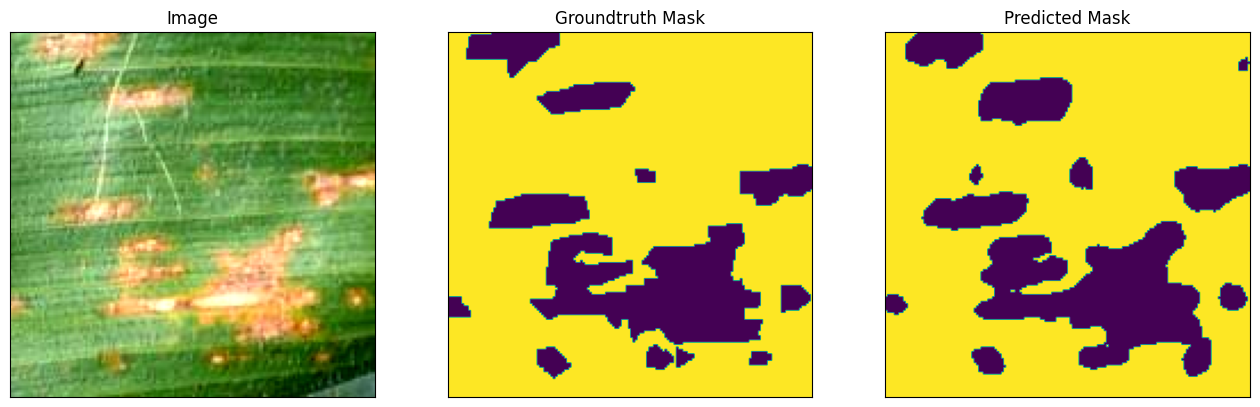

In [39]:
n = 10
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:

    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    visualize(
        image=denormalize(image.squeeze()),
        Groundtruth_mask=gt_mask[..., 0].squeeze(),
        Predicted_mask=pr_mask[..., 0].squeeze(),
    )